# Deep fake burgers generation notebook

## Basic imports

In [1]:
import numpy as np 
import os
from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image
from subprocess import check_output
from scipy import ndimage



import keras.backend.tensorflow_backend as ktf
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import scipy.ndimage
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, Image

Using TensorFlow backend.


In [2]:
## Clean GPU memory

In [3]:
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tensorflow.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.Session(config=config))

In [4]:
def get_session(gpu_fraction=1):
    num_threads = os.environ.get('OMP_NUM_THREADS')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)

    if num_threads:
        return tf.Session(config=tf.ConfigProto(
            gpu_options=gpu_options, intra_op_parallelism_threads=num_threads))
    else:
        return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

ktf.set_session(get_session())

## Passing the training folder

In [5]:
folder = "./burgers_original_64x64/"
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

print("{0} Burgers images found".format(len(onlyfiles)))

267 Burgers images found


## Converting images to arrays

In [6]:
train_files = []
i=0
for _file in onlyfiles:
    train_files.append(_file)

# Original Dimensions
image_width = 64
image_height = 64

# Colored Images
channels = 3
nb_classes = 1

dataset = np.ndarray(shape=(len(train_files), channels, image_height, image_width),
                     dtype=np.float32)

for i, _file in enumerate(train_files):
    img = load_img(folder + "/" + _file)  # this is a PIL image
    img.thumbnail((image_width, image_height))
    # Convert to Numpy Array
    x = img_to_array(img)  
    x = x.reshape((3, 64, 64))
    # Normalize
    x = x / 255.0
    dataset[i] = x
    
print("All %d images in train_files to array !" % len(train_files))
print('Array shape:', dataset.shape)
dataset = dataset.reshape((dataset.shape[0], 64, 64, 3))

All 267 images in train_files to array !
Array shape: (267, 3, 64, 64)


## We check that the obtained np arrays are representing the burgers:

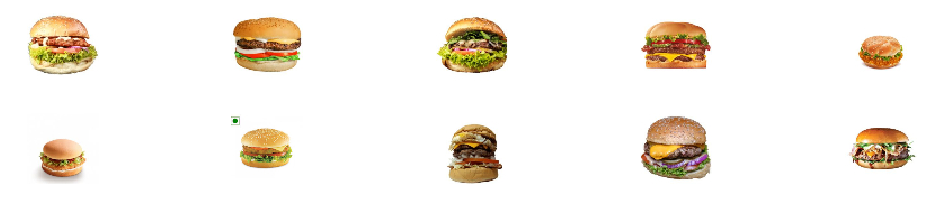

In [7]:
def select_random_images(batch_size, dataset):
    row_i = np.random.choice(dataset.shape[0], batch_size)
    return dataset[row_i, :]

count = 10
examples = select_random_images(count, dataset)

plt.figure(figsize=(15,3))
for i in range(count):
    plt.subplot(2, count // 2, i+1)
    plt.imshow(examples[i])
    plt.axis('off')
    
plt.tight_layout()
plt.show()


# Discriminator:

In [8]:
def discriminator():
    
    net = Sequential()
    input_shape = (64, 64, 3)
    dropout_prob = 0.4

    net.add(Conv2D(32, 5, strides=2, input_shape=input_shape, padding='same'))
    net.add(LeakyReLU())
    
    net.add(Conv2D(64, 5, strides=2, padding='same'))
    net.add(LeakyReLU())
    net.add(Dropout(dropout_prob))
    
    net.add(Conv2D(256, 5, strides=2, padding='same'))
    net.add(LeakyReLU())
    net.add(Dropout(dropout_prob))
    
    net.add(Conv2D(512, 5, strides=2, padding='same'))
    net.add(LeakyReLU())
    net.add(Dropout(dropout_prob))
    
    net.add(Flatten())
    net.add(Dense(1))
    net.add(Activation('sigmoid'))
    
    return net

In [9]:
net_discriminator = discriminator()
net_discriminator.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        2432      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)    

# Generator:

In [16]:
def generator():
    net = Sequential()
    dropout_prob = 0.2
    
    net.add(Dense(8*8*256, input_dim=100))
    net.add(BatchNormalization(momentum=0.9))
    net.add(Activation('relu'))
    net.add(Reshape((8,8,256)))
    net.add(Dropout(dropout_prob))
    
    net.add(UpSampling2D())
    net.add(Conv2D(256, 5, padding='same'))
    net.add(BatchNormalization(momentum=0.9))
    net.add(Activation('relu'))
    
    net.add(UpSampling2D())
    net.add(Conv2D(256, 5, padding='same'))
    net.add(BatchNormalization(momentum=0.9))
    net.add(Activation('relu'))
    
    net.add(UpSampling2D())
    net.add(Conv2D(512, 5, padding='same'))
    net.add(BatchNormalization(momentum=0.9))
    net.add(Activation('relu'))
    
    net.add(Conv2D(1024, 5, padding='same'))
    net.add(BatchNormalization(momentum=0.9))
    net.add(Activation('relu'))
    
    net.add(Conv2D(3, 5, padding='same'))
    net.add(Activation('sigmoid'))
    return net

In [17]:
net_generator = generator()
net_generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16384)             1654784   
_________________________________________________________________
batch_normalization_5 (Batch (None, 16384)             65536     
_________________________________________________________________
activation_7 (Activation)    (None, 16384)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 8, 256)         0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 256)       1638656   
__________

In [18]:
# optim_discriminator = RMSprop(lr=0.0005, clipvalue=1.0, decay=6e-8)
optim_discriminator = Adam(0.0002,0.5)
model_discriminator = Sequential()
model_discriminator.add(net_discriminator)
model_discriminator.compile(loss='binary_crossentropy', optimizer=optim_discriminator, metrics=['accuracy'])

In [19]:
optim_adversarial = Adam(0.0002,0.5)
model_adversarial = Sequential()
model_adversarial.add(net_generator)

# Disable layers in discriminator
for layer in net_discriminator.layers:
    layer.trainable = False

model_adversarial.add(net_discriminator)
model_adversarial.compile(loss='binary_crossentropy', optimizer=optim_adversarial, metrics=['accuracy'])

# Training:

## Let your GPU do the magic

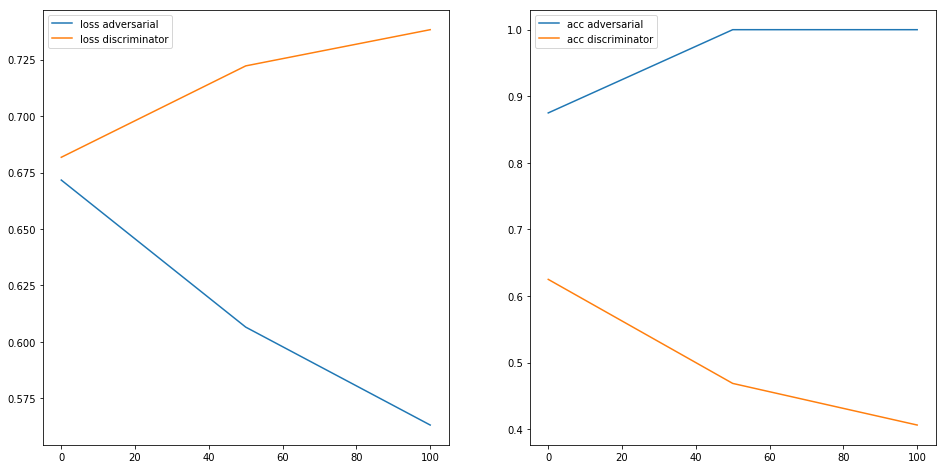

In [ ]:
number_of_epochs = 10001
batch_size = 16

vis_noise = np.random.uniform(-1.0, 1.0, size=[16, 100])

loss_adv = []
loss_dis = []
acc_adv = []
acc_dis = []
plot_iteration = []

for i in range(0, number_of_epochs):
    images_train = select_random_images(batch_size, dataset)
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
    images_fake = net_generator.predict(noise)
    
    x = np.concatenate((images_train, images_fake))
    y = np.ones([2*batch_size, 1])
    y[batch_size:, :] = 0 

    # Train discriminator for one batch
    d_stats = model_discriminator.train_on_batch(x, y)
    
    y = np.ones([batch_size, 1])
    # Train the generator for a number of times
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
    a_stats = model_adversarial.train_on_batch(noise, y)
        
    if i % 50 == 0:
        plot_iteration.append(i)
        loss_adv.append(a_stats[0])
        loss_dis.append(d_stats[0])
        acc_adv.append(a_stats[1])
        acc_dis.append(d_stats[1])

        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(1,2)
        fig.set_size_inches(16, 8)

        ax1.plot(plot_iteration, loss_adv, label="loss adversarial")
        ax1.plot(plot_iteration, loss_dis, label="loss discriminator")
        #ax1.set_ylim([0,5])
        ax1.legend()

        ax2.plot(plot_iteration, acc_adv, label="acc adversarial")
        ax2.plot(plot_iteration, acc_dis, label="acc discriminator")
        ax2.legend()

        plt.show()
    
    if (i < 1000 and i%50 == 0) or (i % 100 == 0):
        images = net_generator.predict(vis_noise)
        
        # Map back to original range
        #images = (images + 1 ) * 0.5
        
        plt.figure(figsize=(10,10))
        for im in range(images.shape[0]):
            plt.subplot(4, 4, im+1)
            image = images[im, :, :, :]
            image = np.reshape(image, [64,64,3])
            plt.imshow(image)
            plt.axis('off')
        plt.tight_layout()
        plt.savefig(r'fake_burgers/{}.png'.format(i))
        plt.close('all')

In [ ]:
import imageio
folder = "./fake_burgers/"
limages = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
images = [] 
for im in limages:
    images.append(imageio.imread('./fake_burgers/'+im))
imageio.mimsave('burgers.gif', images)


# Results:

![SegmentLocal](burgers.gif "segment")